Copy-and-pasted from https://github.com/nengo/nengo_1.4/tree/master/simulator-ui/python/stats/plot

In [11]:
%matplotlib inline

import numpy
import matplotlib
import scipy.ndimage
import scipy.cluster
import pylab

class Plot:
    def __init__(self,dpi=100,width=6,height=4,
                      border_left=0.7,border_right=0.2,border_top=0.2,border_bottom=0.5,
                      color=True):
        self.fig=pylab.figure(figsize=(width,height),dpi=dpi)
        self.theme=ThemePhi(color=color)
        self.fig.subplots_adjust(hspace=0,left=float(border_left)/width,right=1.0-float(border_right)/width,
                                            bottom=float(border_bottom)/height,top=1.0-float(border_top)/height)        
        self.axes=self.fig.add_subplot(1,1,1)
        self.legend_item={}
    def flatten(self,value,depth):
        if depth==1:
            return list(flatten1(value))    
        elif depth==2:    
            return list(flatten2(value))    
        else:
            if not hasattr(value,'shape'):
                value=numpy.array(value)
            shape=list(value.shape)
            while len(shape)<depth:
                shape=[1]+shape
            while len(shape)>depth:
                shape=[shape[0]*shape[1]]+shape[2:]
            value.shape=shape
            return value                    
    def legend(self,labels):
        items=[self.legend_item.get(i,None) for i in range(len(labels))]
        self.axes.legend(items,labels,loc='best')    
    def save(self,filename,dpi=300):
        self.fig.savefig(filename,dpi=dpi)    

    def show(self):
        pylab.show()
        
class Theme:
    def __init__(self):
        self.bar_colors=['0.4','0.8','0.6','1.0']
    def bar_color(self,i):
        return self.bar_colors[i%len(self.bar_colors)]

class ThemePhi:
    def __init__(self,color=True):
        self.phi=(1+numpy.sqrt(5))/2-1
        self.phi2=(1+numpy.sqrt(7))/2-1
        self.start_y=0.5
        self.start_theta=1.7
        self.color=color
        #self.test_plot()
    def theta_to_rb(self,theta):
            b=numpy.sin(theta)
            r=numpy.cos(theta)
            # move to extremes of color space
            if abs(r)>abs(b):
                if r>0:
                    b=b/r
                    r=1.0
                else:
                    b=b/-r
                    r=-1.0
            else:        
                if b>0:
                    r=r/b
                    b=1.0
                else:
                    b=r/-b
                    b=-1.0
            return r,b        
    
    def bar_color(self,i):
        return self.make_color(i,max_y=0.9,min_y=0.0)        
    def line_color(self,i):
        return self.make_color(i,max_y=0.8,min_y=0.1)        
        
    def make_color(self,i,max_y=1.0,min_y=0):
        y=((self.phi*i+self.start_y)%1)*(max_y-min_y)+min_y
        if self.color:
            theta=self.phi*i*2.8+self.start_theta
            r,b=self.theta_to_rb(theta)
        else:
            r,b=0,0    
        return self.ybr_to_color(y,b*0.5+0.5,r*0.5+0.5)
    
    def ybr_to_color(self,y,cb,cr):
        r=y+1.402*(cr-0.5)
        g=y-0.34414*(cb-0.5)-0.71414*(cr-0.5)
        b=y+1.772*(cb-0.5)
        r=int(r*255)
        g=int(g*255)
        b=int(b*255)
        if r<0: r=0
        if g<0: g=0
        if b<0: b=0
        if r>255: r=255
        if g>255: g=255
        if b>255: b=255
        return '#%02x%02x%02x'%(r,g,b)
    def test_plot(self):
        data=[]
        for i in range(20):
            y=((self.phi*i+self.start_y)%1)*(self.max_y-self.min_y)+self.min_y
            theta=(self.phi*i)+self.start_theta
            theta=theta%(2*numpy.pi)
            data.append((y,theta))
        import pylab
        pylab.scatter(numpy.array(data)[:,0],numpy.array(data)[:,1])
        pylab.show()        
        
class Time(Plot):
    def __init__(self, time, time_range=None, ylabel_rotation='vertical', **args):
        Plot.__init__(self,**args)
        self.time = time
        self.xlim = time_range
        self.ylabel_rotation = ylabel_rotation
        self.subplots = []
        self.heights = []
    def _fix_plots(self):
        totalh=float(sum(self.heights))
        space=self.fig.subplotpars.top-self.fig.subplotpars.bottom
        y=self.fig.subplotpars.top
        for i,plot in enumerate(self.subplots):
            h=space/totalh*self.heights[i]
            plot.set_position((self.fig.subplotpars.left,y-h,self.fig.subplotpars.right-self.fig.subplotpars.left,h))
            y-=h

            if i<len(self.subplots)-1:
                plot.set_xticklabels(['']*len(plot.get_xticks()))  
                plot.set_xlabel('')
            else:
                plot.set_xlabel('time (s)')    
            
    def _create_axes(self,label,height):
        self.heights.append(height)
        if len(self.subplots)==0:
            axes=self.axes
        else:
            axes=self.fig.add_subplot(len(self.subplots)+1,1,len(self.subplots)+1)
        if self.xlim is not None: axes.set_xlim(self.xlim)    
        self.subplots.append(axes)
        self._fix_plots()
        
        axes.set_ylabel(label, rotation=self.ylabel_rotation)
        return axes
            
    def _add_overlays(self, axes, overlays):
        min, max = axes.get_ylim()
        mid = (min+max)/2
        for t, text in overlays:        
            axes.text(t, mid, text, ha='center', va='center', 
                      fontsize=12, weight='bold')
            
    def add(self, label, data, height=1, linewidth=1, range=None, 
                  overlays=[]):
        axes=self._create_axes(label,height)
                
        if len(data.shape)<2:
            data=numpy.array([data])
        for i,line in enumerate(data.T):
            c=self.theme.line_color(i)
            axes.plot(self.time,line,color=c,linewidth=linewidth)
        if range is not None:
            axes.set_ylim(range)    
        self._add_overlays(axes, overlays)    
            
    def add_spikes(self, label, data, height=1, sample_by_variance=None,
                         sample=None, sample_filter_width=20,
                         cluster=False, cluster_filter_width=2,
                         merge=None, contrast_scale=1.0, yticks=None,
                         style='image', sample_index=None, cluster_index=None,
                         overlays=[]):
        axes=self._create_axes(label,height)
        
        if sample_index:
            data = data[:, sample_index]    
        elif sample_by_variance is not None and sample_by_variance<len(data.T):
            dd=scipy.ndimage.gaussian_filter1d(data.astype(float).T,sample_filter_width,axis=1)
            vard=numpy.var(dd,axis=1)
                        
            threshold=sorted(vard)[-sample_by_variance]                        
            index=[k for k,v in enumerate(vard) if v>=threshold]
            data=data[:,index]
            self.sample_index = index
        if sample is not None and sample<len(data.T):    
            stepsize=float(len(data.T))/sample
            data2=[]
            for k in range(sample):
                sub=data[:,int(k*stepsize):int((k+1)*stepsize)]
                count=numpy.sum(sub,axis=0)
                maxv=max(count)
                for i,v in enumerate(count):
                    if v==maxv: 
                        data2.append(sub[:,i])
                        break
            data=numpy.array(data2).T    
            
        if cluster_index:
            data = data[:, cluster_index]    
        elif cluster:
            dd=scipy.ndimage.gaussian_filter1d(data.astype(float).T,cluster_filter_width,axis=1)
            z=scipy.cluster.hierarchy.linkage(dd)
            tree=scipy.cluster.hierarchy.to_tree(z)
            order=tree.pre_order()
            data=data[:,order]
            self.cluster_index = order
        if merge is not None and merge<len(data.T):    
            stepsize=float(len(data.T))/merge
            data2=[]
            for k in range(merge):
                v=numpy.sum(data[:,int(k*stepsize):int((k+1)*stepsize)],axis=1)
                data2.append(v)
            data=numpy.array(data2).T    
                            
        if style=='image':                    
            imgplt=axes.imshow(data.T,aspect='auto',cmap=matplotlib.cm.gray_r,interpolation='nearest',extent=(self.time[0],self.time[-1],0,len(data.T)))
            imgplt.set_clim(0.0,numpy.max(data)*contrast_scale)
        elif style=='box':
            vmax=float(numpy.max(data))
            N=len(data.T)
            dt=self.time[1]-self.time[0]
            for i,t in enumerate(self.time):
                t=t[0]
                for j in range(N):
                    if data[i][j]>0:
                        c=(1.0-data[i][j]/(vmax*contrast_scale))
                        if c<0: c=0
                        c='%0.2f'%c
                       
                        axes.axvspan(t,t+dt,1.0-(j+1)/float(N),1.0-(j)/float(N),fc=c,linewidth=0)
            axes.set_ylim((0,N))            
        elif style=='dot':
            vmax=float(numpy.max(data))
            N=len(data.T)
            for i,t in enumerate(self.time):
                t=t[0]
                neurons=[]
                colors=[]
                for j in range(N):
                    if data[i][j]>0:
                        c=(1.0-data[i][j]/(vmax*contrast_scale))
                        if c<0: c=0
                        c='%0.2f'%c
                        colors.append(c)
                        neurons.append(N-j-1)
                if len(neurons)>0:        
                    axes.scatter([t]*len(neurons),neurons,s=1,c=colors,linewidths=0,marker='o')
            axes.set_ylim((0,N))            
            
            
        
        if yticks is None:
            axes.set_yticklabels(['']*len(axes.get_yticks()))  
        else:
            delta=float(len(data.T))/len(yticks)
            vals=[(len(yticks)-i-0.5)*delta for i in range(len(yticks))]
            axes.set_yticks(vals)
            axes.set_yticklabels(yticks)
                
        self._add_overlays(axes, overlays)        

In [19]:
import nengo
model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: numpy.sin(t*numpy.pi*2))
    a = nengo.Ensemble(2000, 1)
    nengo.Connection(stim, a)
    p_spikes = nengo.Probe(a.neurons)
sim = nengo.Simulator(model)
sim.run(2)


Simulation finished in 0:00:01.                                                 


This will take the 1000 neurons with the highest variance, cluster them, and then merge them into 50 rows.

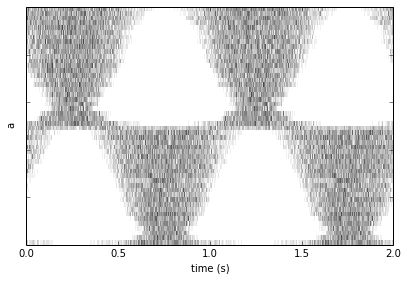

In [20]:
plt = Time(sim.trange())
plt.add_spikes('a', sim.data[p_spikes], sample_by_variance=1000, cluster=True, merge=50)
pylab.show()
